In [1]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CW308_STM32F3'
SS_VER = 'SS_VER_2_1'
PATH = "/home/xjaros2/Documents/git/csidh-setup/csidh-target/src/"
attack_type = "A1"

In [2]:
from csidh import CSIDHCW
import chipwhisperer as cw
from tqdm import tqdm
import random

In [ ]:
csidh = CSIDHCW(PATH, attack_type=attack_type)
csidh.setup()

In [ ]:
csidh.flash_target()

In [ ]:
csidh.scope.adc.timeout = 5

In [ ]:
csidh.reset_target()
csidh.scope.arm()
csidh.action()
ret = csidh.scope.capture()
if ret:
    print("Timeout happened during acquisition")
PUBLIC_EXPECTED = csidh.public_with_errors
max_ext_offset = csidh.scope.adc.trig_count
print("Public key:", PUBLIC_EXPECTED)
print("Max ext offset:", max_ext_offset)

In [ ]:
EXT_OFFSET_FULL = 10528968
print(EXT_OFFSET_FULL - 10055348)
print(EXT_OFFSET_FULL - 10054576)
print(EXT_OFFSET_FULL - 10055640)

In [30]:
# isogeny_offsets = [
#     (5,474252), # The if statement in both branches before isogenies cost 8 cycles  
#     (7,574920),
#     (5,1109332),
#     (3,1638652),
#     (5,1799384),
#     (7,1952772),
#     (3,2377220)
# ]
isogeny_offsets = [
    (5, 118555, 139478),
    (7, 161541, 175472),
    (5, 312859, 333855), 
    (3, 462833, 478086),
    (5, 508058, 529109),
    (7, 551170, 565075),
    (3, 672017, 687331),
    #(3, 717500, 738726)
]



In [ ]:
#csidh.voltage_glitching_setup()
csidh.scope.cglitch_setup()

In [ ]:
from csidh.search import Unit, generate_population, write_cache_to_file
from collections import OrderedDict
import numpy as np
cache = OrderedDict()


def evaluate_unit(csidh, unit, num_measurements=5):
    """Evaluates a single unit"""
    csidh.scope.glitch.num_glitches = 1
    if csidh.scope._is_husky:
        csidh.scope.glitch.width = int(unit.width)
        csidh.scope.glitch.offset = int(unit.offset)
        if not isinstance(unit.repeat, list):
            csidh.scope.glitch.repeat = int(unit.repeat)
            csidh.scope.glitch.ext_offset = int(unit.ext_offset)
        else:
            csidh.scope.glitch.repeat = unit.repeat
            csidh.scope.glitch.ext_offset = unit.ext_offset
    else:
        csidh.scope.glitch.width = unit.width
        csidh.scope.glitch.offset = unit.offset
        csidh.scope.glitch.repeat = unit.repeat
        csidh.scope.glitch.ext_offset = unit.ext_offset

    # Perform the measurements
    measurements = []
    responses = []

    for _ in range(num_measurements):
        csidh.reset_target()
        csidh.scope.glitch.state = None
        csidh.scope.arm()
        ret = csidh.action()
        csidh.scope.io.vglitch_reset()
        if ret:
            logging.error("Timeout happened during acquisition")


        public_received = csidh.public_with_errors
        if not isinstance(public_received, int):
            measurements.append("RESET")
        elif public_received == PUBLIC_EXPECTED:
            measurements.append("NORMAL")
        else:
            measurements.append("JUSTRIGHT")
            responses.append(public_received)

    unit.width = csidh.scope.glitch.width  # CW rounds the values
    unit.offset = csidh.scope.glitch.offset
    unit.repeat = csidh.scope.glitch.repeat
    unit.measurements = measurements
    unit.responses = responses
    

    # Classify
    if not all(m == measurements[0] for m in measurements):
        unit.type = "CHANGING"
        N_normal = sum(1 for m in measurements if m == "NORMAL")
        N_reset = sum(1 for m in measurements if m == "RESET")
        N_justright = sum(1 for m in measurements if m == "JUSTRIGHT")
        unit.fitness = 4 + 1.2 * N_justright + 0.2 * N_normal + 0.5 * N_reset
    else:
        if measurements[0] == "NORMAL":
            unit.type = "NORMAL"
            unit.fitness = 2
        elif measurements[0] == "RESET":
            unit.type = "RESET"
            unit.fitness = 5
        elif measurements[0] == "JUSTRIGHT":
            unit.type = "JUSTRIGHT"
            unit.fitness = 10
    cache[unit] = unit.fitness
    #if unit.type in ["RESET", "JUSTRIGHT"]:
    print(unit)
    print(unit.measurements)
    print(unit.responses)


def evaluate_batch(csidh, population):
    uncached = [u for u in population if u not in cache]
    if not uncached:
        return [u.fitness for u in population]

    to_visit = np.array(uncached)

    for unit in population:
        if unit in cache:
            unit.fitness = cache[unit]

    for unit in to_visit:
        evaluate_unit(csidh, unit)

    return [u.fitness for u in population]

In [ ]:
def generate_whole_population():
    population = []
    for offset in range(Unit.OFFSET_MIN, Unit.OFFSET_MAX+1):
        for width in range(Unit.WIDTH_MIN, Unit.WIDTH_MAX+1):
            for ext_offset in range(Unit.EXT_OFFSET_MIN, Unit.EXT_OFFSET_MAX+1):
                for repeat in range(Unit.REPEAT_MIN, Unit.REPEAT_MAX+1):
                    unit = Unit(repr=f"{ext_offset},{offset},{width},{repeat},None,0")
                    population.append(unit)
    return population

In [1]:
from copy import deepcopy
import json
import pandas as pd
import seaborn as sns
from csidh.search import Unit

import os
os.chdir("/home/xjaros2/Documents/git/csidh-setup/csidh-target/scripts/")

def read_cachefile(filename):
    with open(filename, "r") as f:
        measurements = json.load(f)
    measurements = measurements["measurements"]
    result = []
    for i in range(len(measurements)):
        unit = Unit(repr=measurements[i]["unit"])
        measurements[i].update(unit.__dict__())
        unit.measurements = measurements[i]["measurements"]
        unit.responses = measurements[i]["responses"]
        del measurements[i]["index"]
        measurements[i]["unit"] = unit
        result.append(measurements[i])
    return result

def read_cachefiles_to_dataframe(cachefiles):
    df = None
    for filename in cachefiles:
        result = pd.DataFrame(read_cachefile(filename))
        if df is None:
            df = result
        else:
            df = pd.concat([df, result], ignore_index=True, sort=False)
    return df

In [2]:
husky = [
    "./husky-clock-ISOGENY-SKIP-SEARCH.json"
]

df = read_cachefiles_to_dataframe(husky)
#df = df[df["type"] == "JUSTRIGHT"].reset_index()
df

,unit,responses,measurements,ext_offset,offset,width,repeat,type,fitness,offset_fine,width_fine
0,"(ext_offset=99156, offset=4426, width=271, rep...",[],[NORMAL],99156,4426,271,8,NORMAL,2.0,None,None
1,"(ext_offset=143791, offset=4426, width=271, re...",[],[RESET],143791,4426,271,8,RESET,5.0,None,None
2,"(ext_offset=244442, offset=4426, width=271, re...",[],[NORMAL],244442,4426,271,8,NORMAL,2.0,None,None
3,"(ext_offset=374110, offset=4426, width=271, re...",[],[RESET],374110,4426,271,8,RESET,5.0,None,None
4,"(ext_offset=502756, offset=4426, width=271, re...",[],[RESET],502756,4426,271,8,RESET,5.0,None,None
...,...,...,...,...,...,...,...,...,...,...,...
71868,"(ext_offset=202749, offset=147, width=174, rep...",[],[NORMAL],202749,147,174,7,NORMAL,2.0,None,None
71869,"(ext_offset=426090, offset=147, width=174, rep...",[],[NORMAL],426090,147,174,7,NORMAL,2.0,None,None
71870,"(ext_offset=499889, offset=147, width=174, rep...",[],[RESET],499889,147,174,7,RESET,5.0,None,None
71871,"(ext_offset=545996, offset=147, width=174, rep...",[],[RESET],545996,147,174,7,RESET,5.0,None,None


In [3]:
from csidh import CSIDHDLL
PATH = "/home/xjaros2/Documents/git/csidh-setup/csidh-target/src/"
csidhdll = CSIDHDLL(src_path=PATH)


def isogeny_in_distance(public, i):
    csidhdll.public = csidhdll.to_projective(public)
    private = [0, 0, 0]
    
    private[i] = -1
    csidhdll.private = private
    positive_isogeny_skipped =  csidhdll.from_projective(csidhdll.action())

    private[i] = 1
    csidhdll.private = private
    negative_isogeny_skipped = csidhdll.from_projective(csidhdll.action())
    return [positive_isogeny_skipped, negative_isogeny_skipped]

-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /home/xjaros2/Documents/git/csidh-setup/csidh-target/src/build
[100%] Built target csidh


In [4]:
SINGLE_ISOGENY_PUBLIC_SKIPS = isogeny_in_distance(0, 0)+ isogeny_in_distance(0, 1)+ isogeny_in_distance(0, 2)
SINGLE_ISOGENY_PUBLIC_SKIPS

[261, 158, 220, 199, 344, 75]

In [26]:
potential_skips = df.iloc[[i for i, x in enumerate(df["responses"]) if any(y in x for y in SINGLE_ISOGENY_PUBLIC_SKIPS)]]
potential_skips.responses = potential_skips.responses.apply(lambda x: x[0])
potential_skips

/tmp/nix-shell.XcXum7/ipykernel_1064175/3858077411.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  potential_skips.responses = potential_skips.responses.apply(lambda x: x[0])


,unit,responses,measurements,ext_offset,offset,width,repeat,type,fitness,offset_fine,width_fine
265,"(ext_offset=640713, offset=4178, width=599, re...",158,[JUSTRIGHT],640713,4178,599,4,JUSTRIGHT,10.0,None,None
630,"(ext_offset=21200, offset=3944, width=152, rep...",199,[JUSTRIGHT],21200,3944,152,15,JUSTRIGHT,10.0,None,None
696,"(ext_offset=439145, offset=3944, width=152, re...",220,[JUSTRIGHT],439145,3944,152,15,JUSTRIGHT,10.0,None,None
1158,"(ext_offset=432613, offset=4044, width=601, re...",344,[JUSTRIGHT],432613,4044,601,12,JUSTRIGHT,10.0,None,None
1195,"(ext_offset=545972, offset=4416, width=607, re...",344,[JUSTRIGHT],545972,4416,607,14,JUSTRIGHT,10.0,None,None
...,...,...,...,...,...,...,...,...,...,...,...
71115,"(ext_offset=484348, offset=4051, width=297, re...",344,[JUSTRIGHT],484348,4051,297,4,JUSTRIGHT,10.0,None,None
71145,"(ext_offset=649671, offset=4207, width=512, re...",344,[JUSTRIGHT],649671,4207,512,17,JUSTRIGHT,10.0,None,None
71202,"(ext_offset=83611, offset=3883, width=451, rep...",261,[JUSTRIGHT],83611,3883,451,17,JUSTRIGHT,10.0,None,None
71362,"(ext_offset=642442, offset=131, width=390, rep...",344,[JUSTRIGHT],642442,131,390,11,JUSTRIGHT,10.0,None,None


In [63]:
skips =  df[df["responses"].isin([[x] for x in SINGLE_ISOGENY_PUBLIC_SKIPS])]
stats = {
    "Total": len(df),
    "Normal": len(df[df.type == "NORMAL"]),
    "Reset": len(df[df.type == "RESET"]),
    "Justright": len(df[df.type == "JUSTRIGHT"]),
    "(+)3" : len(df[df["responses"].isin([[261]])]),
    "(-)3" : len(df[df["responses"].isin([[158]])]),
    "(+)5" : len(df[df["responses"].isin([[220]])]),
    "(-)5" : len(df[df["responses"].isin([[199]])]),
    "(+)7" : len(df[df["responses"].isin([[344]])]),
    "(-)7" : len(df[df["responses"].isin([[75]])]),
    "skipped": len(skips)
}
percentages = {}
for key in stats:
    percentages[key] = 100 * stats[key]/stats["Total"]
percentages, stats

({'Total': 100.0,
  'Normal': 23.786401012897752,
  'Reset': 74.01527694683678,
  'Justright': 2.1983220402654684,
  '(+)3': 0.05287103641144797,
  '(-)3': 0.0292182043326423,
  '(+)5': 0.04313163496723387,
  '(-)5': 0.292182043326423,
  '(+)7': 0.28105129881874974,
  '(-)7': 0.01808745982496904,
  'skipped': 0.7165416776814659},
 {'Total': 71873,
  'Normal': 17096,
  'Reset': 53197,
  'Justright': 1580,
  '(+)3': 38,
  '(-)3': 21,
  '(+)5': 31,
  '(-)5': 210,
  '(+)7': 202,
  '(-)7': 13,
  'skipped': 515})

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

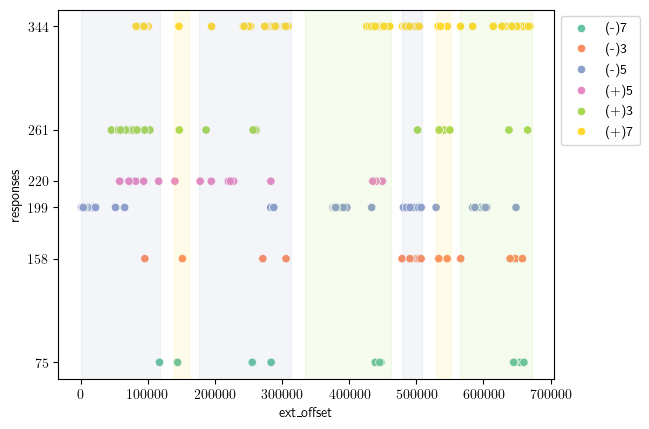

In [53]:
plt.rc('text', usetex=True)

palette = sns.color_palette("Set2", 6).as_hex()[:6]
ax = sns.scatterplot(potential_skips, x="ext_offset", y="responses", hue="responses", palette=palette)
ax.legend().set_title("Isogenies")
for label in ax.legend().texts:
    if label.get_text() == "261":
        label.set_text("(+)3")
    if label.get_text() == "158":
        label.set_text("(-)3")
    if label.get_text() == "220":
        label.set_text("(+)5")
    if label.get_text() == "199":
        label.set_text("(-)5")
    if label.get_text() == "344":
        label.set_text("(+)7")
    if label.get_text() == "75":
        label.set_text("(-)7")

bgmap = {
    3 : palette[4],
    5 : palette[2],
    7 : palette[5]
}

for i in range(len(isogeny_offsets)):
    if i == 0:
        xmin = 0
        xmax = isogeny_offsets[i][1]
    else:
        xmin = isogeny_offsets[i-1][2]
        xmax = isogeny_offsets[i][1]
    l = isogeny_offsets[i][0]
    plt.axvspan(xmin=xmin, xmax=xmax, alpha=0.1, color=bgmap[l])

plt.yticks(SINGLE_ISOGENY_PUBLIC_SKIPS)


sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.savefig("single-isogeny-disorientations.pdf")

In [ ]:
single_skips = list(set(potential_skips["unit"]))

In [ ]:
csidh.scope.glitch.num_glitches = 2

In [ ]:
cache = OrderedDict()
REPEATS = 20000
cache_interval = 2
for _ in tqdm(range(REPEATS//cache_interval)):
    batch = []
    for _ in range(cache_interval):
        i = random.randint(0, len(single_skips)-1)
        j = i
        while j == i:
            j = random.randint(0, len(single_skips)-1)

        fst = single_skips[i]
        snd = single_skips[j]
        swap = lambda x, y: (y, x)
        if fst.ext_offset > snd.ext_offset:
            fst, snd = swap(fst, snd)
            
        unit1 = Unit(repr=repr(fst))
        unit1.repeat = [fst.repeat, fst.repeat]
        unit1.ext_offset = [fst.ext_offset, snd.ext_offset-fst.ext_offset]

        unit2 = Unit(repr=repr(snd))
        unit2.repeat = [snd.repeat, snd.repeat]
        unit2.ext_offset = [fst.ext_offset, snd.ext_offset-fst.ext_offset]
            
        unit3 = Unit(repr=repr(fst))
        unit3.repeat = [fst.repeat, snd.repeat]
        unit3.ext_offset = [fst.ext_offset, snd.ext_offset-fst.ext_offset]

        unit4 = Unit(repr=repr(snd))
        unit4.repeat = [fst.repeat, snd.repeat]
        unit4.ext_offset = [fst.ext_offset, snd.ext_offset-fst.ext_offset]

        print(unit1)
        print(unit2)
        print(unit3)
        print(unit4)
        
        batch.append(unit1)
        batch.append(unit2)       
        batch.append(unit3)
        batch.append(unit4)

    evaluate_batch(csidh, batch)
    write_cache_to_file(f"husky-clock-ISOGENY-DOUBLE-SKIP.json", cache, 1, len(cache), -1)   

In [ ]:
# potential = [
#     "./husky-clock-xISOG-first-5-isogeny-skip-search-until7.json"
# ]

# df = read_cachefiles_to_dataframe(potential)
# df = df[(df["type"] == "JUSTRIGHT")].reset_index()
# indices = [i  for i,x in enumerate(df["responses"]) if 199 in x]
# potential_skips = df.iloc[indices]
# batch = list(set(potential_skips["unit"]))
# batch.sort(key=lambda unit: -unit.ext_offset)
# batch
# cache = OrderedDict()
# uut = batch[-1]
# uut.offset = 2706
# uut.width = 2600
# uut.repeat = 4
# evaluate_batch(csidh, [uut])
# write_cache_to_file(f"first-5-isogeny-potential-skips.json", cache, 1, len(cache), -1)   

In [ ]:
# cache = OrderedDict()
# REPEATS = 20000
# cache_interval = 2
# for _ in tqdm(range(REPEATS//cache_interval)):
#     batch = []
#     for _ in range(cache_interval):
#         i = random.randint(0, len(candidates)-1)
#         base_unit = candidates[i]
#         for j in range(len(isogeny_offsets)):
#             if j == 0:
#                 eof_min = 0
#                 eof_max = isogeny_offsets[0][1]
#             else:
#                 eof_min = isogeny_offsets[j-1][2]
#                 eof_max = isogeny_offsets[j][1]
#             unit = Unit(repr=repr(base_unit))
#             unit.ext_offset = random.randint(eof_min, eof_max)
#             print(unit)
#             batch.append(unit)

#     evaluate_batch(csidh, batch)
#     write_cache_to_file(f"husky-clock-ISOGENY-SKIP-SEARCH.json", cache, 1, len(cache), -1)   

In [ ]:
# cache = OrderedDict()

# REPEATS = 17500
# cache_interval = 10
# for _ in tqdm(range(REPEATS//cache_interval)):
#     batch = []
#     for _ in range(cache_interval):
#         # width = random.randint(2650, 2750)
#         # offset = random.randint(2560, 2610)
#         # repeat = random.randint(4, 5)
#         width = random.randint(0, csidh.scope.glitch.phase_shift_steps//2)
#         offset = random.randint(0, csidh.scope.glitch.phase_shift_steps)
#         repeat = random.randint(1, 18)
        
#         ext_offset = random.randint((474252//4 )+2000, (474252//4 ) + 3200)
    
#         unit = Unit(repr=f"{ext_offset},{offset},{width},{repeat},None,0")
#         batch.append(unit)

#     evaluate_batch(csidh, batch)
#     write_cache_to_file(f"husky-clock-xISOG-first-5-isogeny-skip-parameter-search.json", cache, 1, len(cache), -1)   

In [ ]:
# population = []
# cache = OrderedDict()
# for i, (_, isogeny_offset) in tqdm(enumerate(isogeny_offsets[:1])):
#     Unit.is_husky = csidh.scope._is_husky
#     Unit.OFFSET_MIN = 2705 	 
#     Unit.OFFSET_MAX = 2705 	
#     Unit.OFFSET_RANGE = Unit.OFFSET_MAX - Unit.OFFSET_MIN
    
#     Unit.WIDTH_MIN = 2601
#     Unit.WIDTH_MAX = 2601
#     Unit.WIDTH_RANGE = Unit.WIDTH_MAX - Unit.WIDTH_MIN
    
#     Unit.EXT_OFFSET_MIN = isogeny_offset // 4 + 0
#     Unit.EXT_OFFSET_MAX = isogeny_offset // 4 + 10000
#     Unit.EXT_OFFSET_RANGE = Unit.EXT_OFFSET_MAX - Unit.EXT_OFFSET_MIN
    
#     Unit.REPEAT_MIN = 4
#     Unit.REPEAT_MAX = 4
#     Unit.repeat_range = Unit.REPEAT_MAX - Unit.REPEAT_MIN
#     batch = generate_whole_population()
#     print(f"Evaluating population for Isogeny number: {i}, {Unit.EXT_OFFSET_MIN=}, {Unit.EXT_OFFSET_MAX=}, Batch size: {len(batch)}")
#     population += batch
#     print(len(population))
#     evaluate_batch(csidh, batch)
#     write_cache_to_file(f"xISOG-5-isogeny-skip-test.json", cache, 1, len(population), -1)   